# Glycosylating a membrane

In this tutorial we will glycosylate a membrane scaffold with a glycan. Let's see how!

In [46]:
import glycosylator as gl

First we load the membrane scaffold from a PDB file.

In [47]:
membrane = gl.Membrane.from_pdb("./files/membrane.pdb")

Now we build a glycan to attach onto the membrane. Let's use this one:

<Axes: >

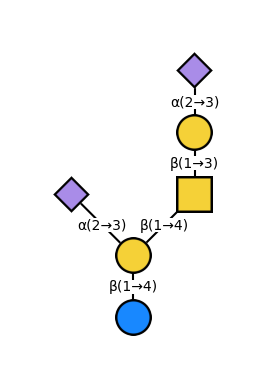

In [48]:
glycan = gl.glycan("Neu5Ac(a2-3)Gal(b1-3)GalNAc(b1-4)[Neu5Ac(a2-3)]Gal(b1-4)Glc", "GD1a")
glycan.snfg()

Now we can start thinking about where to glycosylate our membrane. Our membrane has some ceramide residues in there which is where we want to add glycans to. We can search for the ceramides using `get_residues` and then use `Membrane.glycosylate` to add our glycan. However, we only want to glycosylate one side of the membrane bilayer so we will restrict our search for ceramides to the upper layer which is given by chain `U` in the PDB file (because the PDB file is nicely preprocessed to allow us a smooth workflow, if you don't have a nice file like this you will need to infer which ceramides are in which bilayer by yourself). 

In [49]:
# get all ceramides in the upper layer
ceramides = membrane.get_residues("CER", chain="U")

print(ceramides)

[Residue(CER, 4), Residue(CER, 5), Residue(CER, 23), Residue(CER, 24), Residue(CER, 28), Residue(CER, 29), Residue(CER, 31), Residue(CER, 37), Residue(CER, 40), Residue(CER, 44)]


Next we can glycosylate the membrane using the `glycosylate` method. Here's how:

In [50]:
# glycosylate the first 4 ceramides
membrane.glycosylate(glycan, residues=ceramides[:4])

Membrane(membrane)

And let's also see what the membrane looks like using `py3dmol`

In [51]:
membrane.py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Optimizing a glycosylated membrane

If see some glycans that are clashing with each other or with the membrane itself we should do something about it! Glycans may clash because the overall geometry of the environment is not considered when attaching glycans, so we may need to perform an optimization in order to fix the conformation.

Since Glycosylator is built on BuildAMol we can use the BuildAMol optimization suite to get better conformations for the glycans on our membrane. If you are interested in learning more about conformational optimization using BuildAMol be sure to check out the [tutorials](https://biobuild.readthedocs.io/en/latest/tutorials.html) in the BuildAMol documentation!

In short, to optimize structures we need to perform four steps: 

(1) make a graph representation of the molecule to optimize  and choose bonds to rotate around in order to optimize the conformation

(2) select an optimization environment to evaluate the quality of new conformations

(3) solve the environment to find a good conformation

Here we will outline how we can do this for our glycosylated membrane:



### Step 1 - making a graph

The first step is to get a graph of the membrane. We can either use `Membrane.get_atom_graph()` or `Membrane.get_residue_graph()` to do so. However, if you are working on a not so powerful machine you should go for the residue graph since it is much smaller than the atom graph!

Let's manually make a residue graph here and sample some edges from the glycans to optimize:

In [71]:
# make a copy to work with
membrane_to_optimize = membrane.copy()

In [72]:
# glycosylator comes with a pre-made function to perform steps 1 and 2 automatically. 
# It produces a ResidueGraph for the scaffold and a list of edges that belong to the glycan residues, for optimization.
graph, edges = gl.optimizers.make_scaffold_graph(membrane_to_optimize, only_clashing_glycans=False, include_root=True, slice=3)

# (this will help improve the performance of the optimization)
# (if you are curious why, compare the normal `get_residue_graph` with the one that has called `make_detailed`)
graph.make_detailed(include_far_away=True)

print(len(graph.nodes), len(edges))

/Users/noahhk/anaconda3/envs/glyco2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



1650 12


### Step 2 - making an environment

Now that we have a graph and edges, we need to setup a an environment to evaluate conformations. BuildAMol offers three environments to choose from: the `DistanceRotatron`, the `OverlapRotatron`, and the `ForceFieldRotatron`. The latter is going to require a lot of computation given how large the system is we are trying to optimize so it's best to stay away from that one! For this example we will use the default `DistanceRotatron` which will aim to maximize inter-atomic distances.

In addition to these three basic environments, Glycosylator is equipped with the `ScaffoldRotatron` which adds a little extra on top of either of the three environments mentioned above in order to incentivize conformations that make glycans extend away from the membrane surface. We will ultimately use this environment to optimize our protein. Here's how:

In [73]:
# make the base environment for conformation evaluation
base_env = gl.DistanceRotatron(graph, edges, pushback=2)

# now make the ScaffoldRotatron to incentivize the glycans to stay away from the membrane surface
env = gl.ScaffoldRotatron(base_env)

## Step 3 - optimizing 
Now we can use the environment to optimize the glycans on our membrane. We can use the `optimize` function to solve the environment using an optimization algorithm. We will use a particle-swarm optimization. We could pass more arguments here to further guide the behavior of the swarm optimization...

In [74]:
membrane_to_optimize = gl.optimizers.optimize(membrane_to_optimize, env, algorithm="swarm")

And now we can compare the before-after:

In [75]:
view = membrane.py3dmol(glycan_color="red")
for glycan in membrane_to_optimize.get_glycans().values():
    view.add(glycan.py3dmol(color="cyan"))
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And there we have a bunch of new conformations for our membrane glycans! We can now save our new membrane to another PDB file if we like:

In [77]:
membrane_to_optimize.to_pdb("./files/membrane_optimized.pdb")

And that's it for this tutorial. Hopefully, you now feel ready to glycosylate your own membranes. Of course, the part about optimization is only illustrative and you may need to tinker around to fit it to your system. Thanks for checking out this tutorial and good luck with your project using Glycosylator!